In [1]:
import numpy as np
import matplotlib.pyplot as plt

from auxiliary import values as v
from auxiliary.utils.colors import bcolors as c
from auxiliary.data import imaging

from feature_extraction.feature_extractor import filter_by_margin, filter_by_volume

In [7]:
masks = imaging.read_tiff(
    v.data_path + 'Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff',
    axes='ZYX',
    verbose=1
)
print(masks.shape)

Reading TIFF: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr7/RawImages/Membrane/PreProcessing/confocal_3D_unet_sa_meristem_cells/GASP/PostProcessing/20190403_E2_mGFP_decon_0.5_predictions_gasp_average.tiff
(1024, 1024, 490)


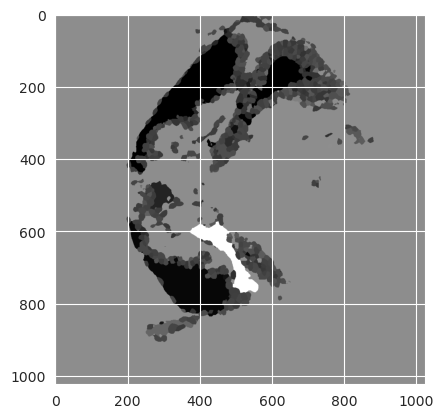

In [8]:
plt.imshow(masks[..., 100], cmap='gray')

In [9]:
masks = filter_by_volume(masks[..., 100:150], verbose=1)

Filtering by volume...
	Found 2546  cells
	Removing 91 cells...



Saving prediction: mask_test.tiff


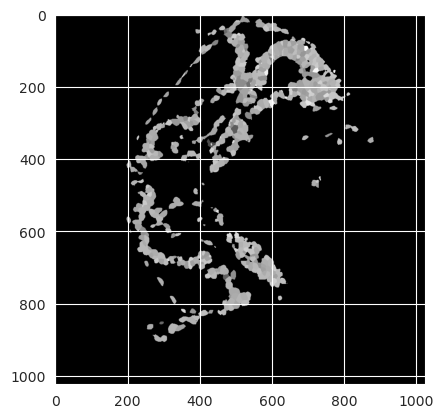

In [11]:
plt.imshow(masks[..., 0], cmap='gray')
imaging.save_prediction(masks, 'mask_test.tiff', verbose=1)

In [14]:
img_path = v.data_path + 'Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz'
img = imaging.read_image(img_path, axes='ZYX', verbose=1)

Reading NIfTI: /run/user/1003/gvfs/smb-share:server=tierra.cnic.es,share=sc/LAB_MT/LAB/Ignacio/Gr1/Segmentation/Nuclei/20190208_E2_mask_PLACEHOLDER.nii.gz
